In [1]:
import numpy as np
from pandas import Series,DataFrame
import pandas as pd
import time
import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl

import scipy.cluster.hierarchy as hcluster
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn import mixture
import itertools
from scipy import linalg
from itertools import cycle

from matplotlib.backends.backend_pdf import PdfPages

import os

%matplotlib inline
mpl.rcParams['figure.figsize'] = (16.0, 6.0)

MINIMUM_COOKING_TIME = 60*10

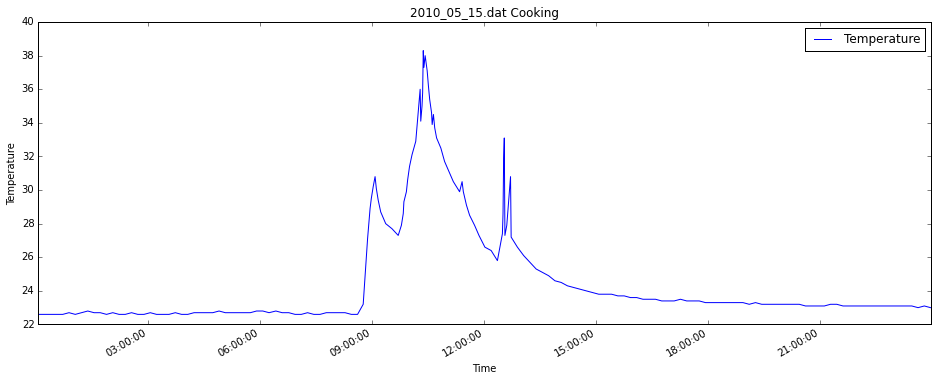

In [2]:
FILE_DIR = "/home/xxx/DS/Bachelor/raw_data/tp1/"
f = "2010_05_15.dat"

# read file
dframe = pd.read_csv(FILE_DIR + f, sep=',', parse_dates=[1], header=None, names=['datetime', 'sec', 'ms', 'event_type', 'event_subtype', 'sensor_id','z','x','y','value', 'something'])
# convert 'datetime' colum to DateTime type
dframe['datetime'] = pd.to_datetime(dframe['datetime'])
# calculate diff in seconds from day begin
dframe['seconddelta'] = dframe.datetime.map( lambda x: pd.to_datetime(x).hour*3600 + pd.to_datetime(x).minute*60 + pd.to_datetime(x).second )
# create new column from existing 'seconddelta' plus milliseconds
dframe['msseconddelta'] = dframe.seconddelta + dframe.ms/1000
# cooking sensor 4 DataFrame
dframes4 = pd.DataFrame(dframe.loc[dframe['sensor_id'] == 4])


ax = dframes4.plot(x='datetime', y='value', title=f + ' Cooking', label="Temperature")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature")

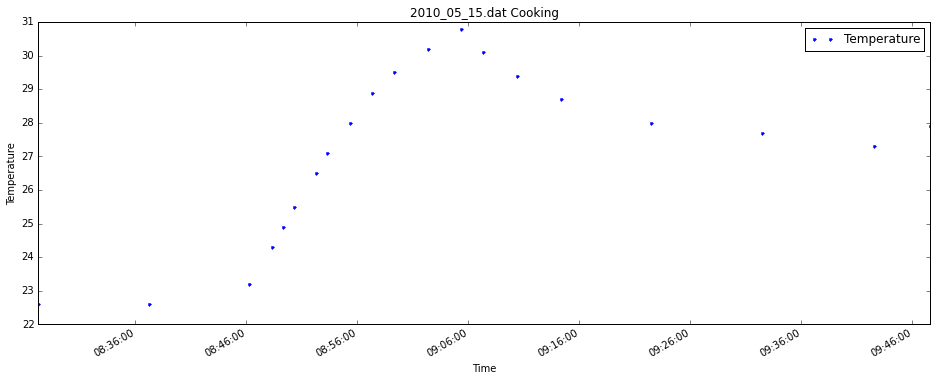

In [3]:
ax = dframes4.ix[1500:2400].plot(x='datetime', y='value', title=f + ' Cooking', label="Temperature", style=".")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature")

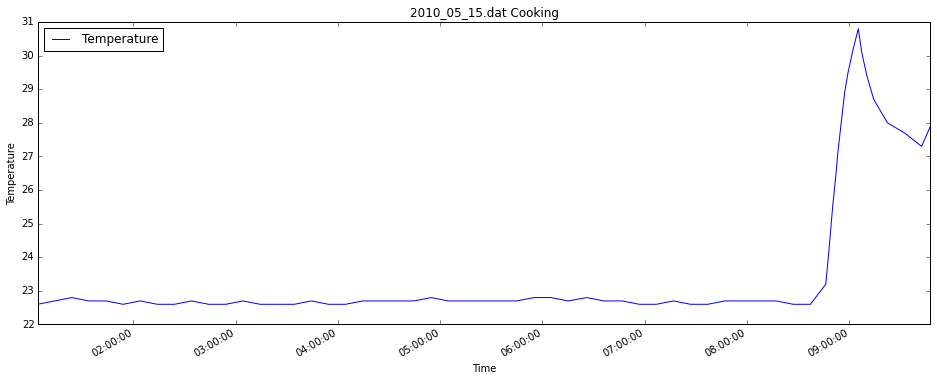

In [4]:
ax = dframes4.ix[100:2400].plot(x='datetime', y='value', title=f + ' Cooking', label="Temperature")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature")

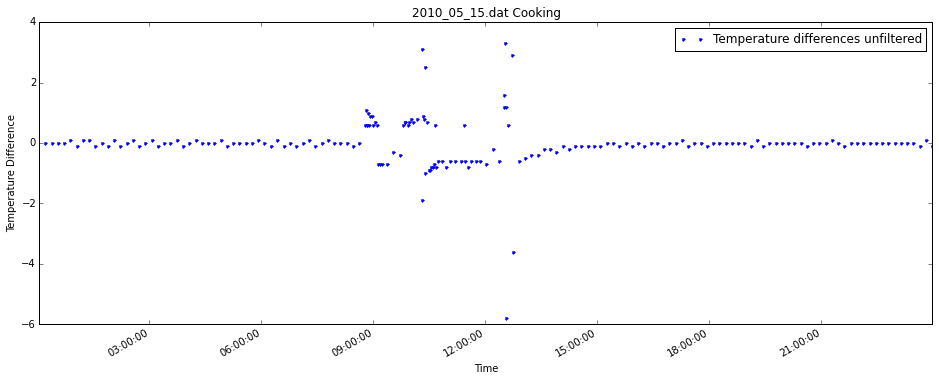

In [5]:
# calculate temperature value difference
dframes4['valuediff'] = dframes4.value.diff()

ax = dframes4.plot(x='datetime', y='valuediff', title=f + ' Cooking', label="Temperature differences unfiltered",style=".")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature Difference")

AttributeError: 'numpy.ndarray' object has no attribute 'log'

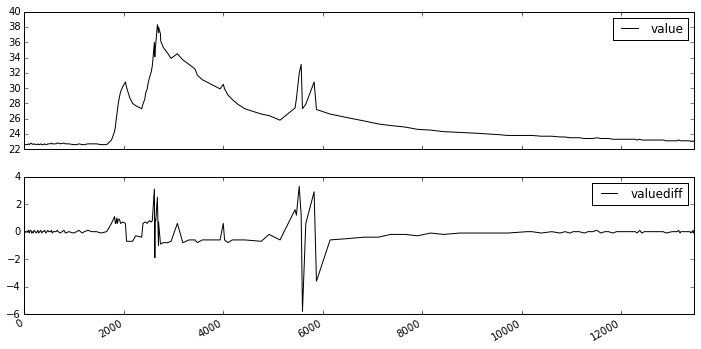

In [23]:
import math
dframes4[["value","valuediff"]].plot(subplots=True, figsize=(12, 6));
#dframes4.values.hist()
print math.log((dframes4.value.values.log() - dframes4.value.values.shift(-1).log))

In [7]:
## As you can see there is a lot of 'noise' in data. Temperature difference
# jumps up and down by 0.1 grad very often.
## That noise needs to be filtered out in order to correctly recognize
# cooking blocks

# First possibility is to take 0.25 quantile value out of valuediff values

In [8]:
print dframes4['valuediff'].describe()

count    180.000000
mean       0.002222
std        0.813775
min       -5.800000
25%       -0.100000
50%        0.000000
75%        0.100000
max        3.300000
Name: valuediff, dtype: float64


In [9]:
## first posibility to filter out the noise in data ##
filter_treshold1 = abs(np.round(dframes4['valuediff'].quantile(.25), decimals=2)) * 2

In [10]:
# Second possibility to flatten the signal is to take 
# most common temperature differences. 
## second posibility to filter out the noise in data ##

from collections import defaultdict
ser = dframes4['valuediff'].value_counts()

# iterate over all temperature difference values and create 
# absolute dictionary for values. 
D = defaultdict(int)
for key in ser.index.values:
    rkey = round(key,1)
    #print abs(rkey), ser[key]
    D[abs(rkey)] += ser[key]

# global counter of all temperature differences
gc = 0
for k in D:
    #print k, D[k]
    gc += D[k]

# parameter (in percentage) to filter all values that ocure more often
FILTER_EVERYTHING_ABOVE = 20
values_to_filterout = []
for k in D:
    print k, D[k], ',%:',(100*D[k])/gc
    # if bigger than 20% add to valies to filterout
    if (100*D[k])/gc >= FILTER_EVERYTHING_ABOVE:
        values_to_filterout.append(k)

0.0 62 ,%: 34
1.0 2 ,%: 1
0.3 2 ,%: 1
0.1 48 ,%: 26
0.8 8 ,%: 4
3.6 1 ,%: 0
0.4 3 ,%: 1
1.2 2 ,%: 1
1.6 1 ,%: 0
0.6 22 ,%: 12
0.2 4 ,%: 2
2.9 1 ,%: 0
5.8 1 ,%: 0
3.1 1 ,%: 0
0.9 5 ,%: 2
1.9 1 ,%: 0
0.7 12 ,%: 6
3.3 1 ,%: 0
0.5 1 ,%: 0
1.1 1 ,%: 0
2.5 1 ,%: 0


In [11]:
# filter treshold 2
filter_treshold2 = 0
if len(values_to_filterout) > 0:
    filter_treshold2 = max(values_to_filterout)*2

In [12]:
# take the highest treshold
# after analysing all data it is obvious that temperature differences 
# most commonly jumps between -0.2 and 0.2 Grad
ft = max([filter_treshold1, filter_treshold2])
if ft > 0.2:
    ft = 0.2

In [13]:
# return 0 for everything that is below filter_treshold parameter
# else return old value
# this method flatens our cooking-temperature signal
def clear_noise(diff, filter_treshold):
    #print "clearnoise with: ", filter_treshold
    if abs(diff) <= filter_treshold:
        return 0
    else:
        return diff
 
# create new column 'valuediffauto'. 
dframes4['valuediffauto'] = dframes4.apply(lambda row: clear_noise(row['valuediff'], ft), axis=1)
# mark with 1 rows with temperature increase.
dframes4['valuebit'] = dframes4.valuediffauto.map( lambda x: x > 0 )

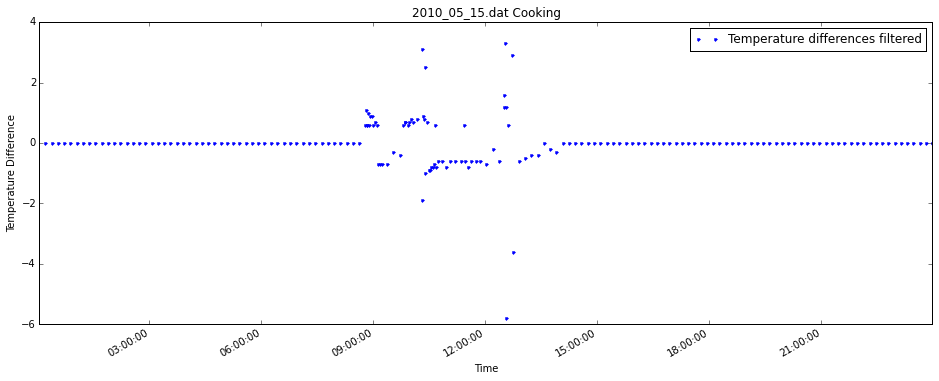

In [14]:
ax = dframes4.plot(x='datetime', y='valuediffauto' , title=f + ' Cooking', style='.',label="Temperature differences filtered")
ax.set_xlabel("Time")
ax.set_ylabel("Temperature Difference")

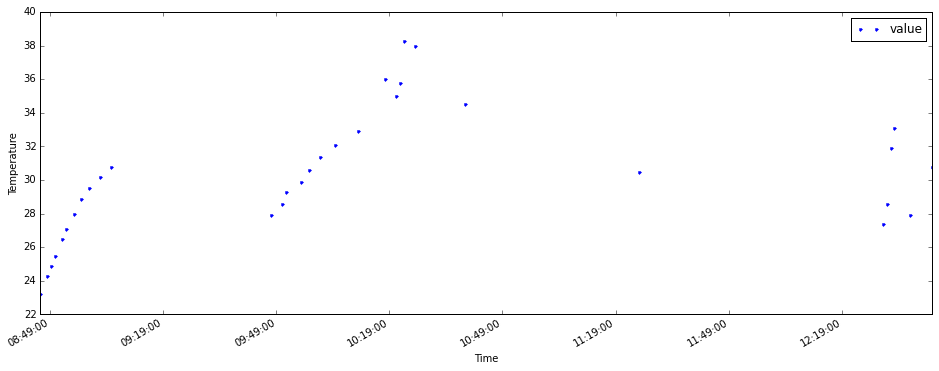

In [15]:
ax=dframes4[dframes4['valuebit']==True].plot(x='datetime', y='value', style='.')
ax.set_xlabel("Time")
ax.set_ylabel("Temperature")

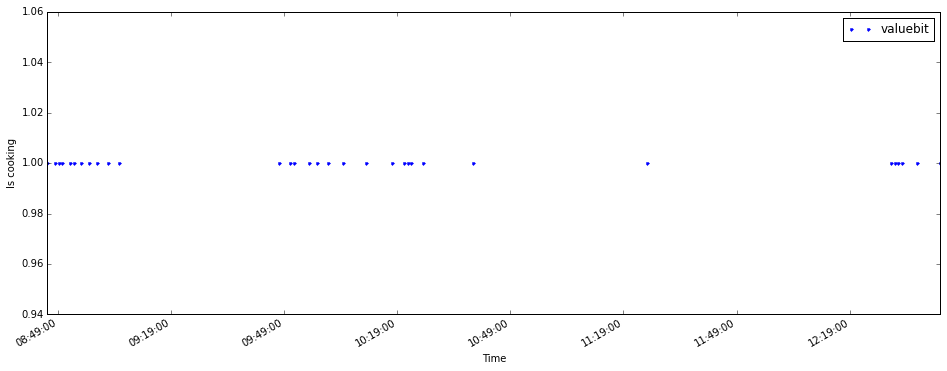

In [16]:
ax=dframes4[dframes4['valuebit']==True].plot(x='datetime', y='valuebit', style='.')
ax.set_xlabel("Time")
ax.set_ylabel("Is cooking")

In [17]:
## marking successive positive temperature differences
prev_row = {}
prev_row['value'] = 'null'
prev_row['valuediffauto'] = 0.0
index = -1
output = index
def block_cooking(row):
    global prev_row, index, output

    # if prev <=0.0 && this > 0.0
    # index = 0
    # return index 
    # index++
    if prev_row['valuediffauto'] <= 0.0 and row['valuediffauto'] > 0.0:
        index = 0
        output = index
        print row['datetime'], row['valuediffauto'], row['value'], ', prev: ', prev_row['value'], ', index: ', index
        index += 1
    # else if prev >= 0.0 && this > 0.0
    # return index
    # index++
    elif prev_row['valuediffauto'] >= 0.0 and row['valuediffauto'] > 0.0:
        output = index
        print row['datetime'], row['valuediffauto'], row['value'], ', prev: ', prev_row['value'], ', index: ', index
        index += 1
    # else if this < 0.0
    # index = 0
    elif row['valuediffauto'] < 0.0:
        index = -1
        output = index
        print row['datetime'], row['valuediffauto'], row['value'], ', prev: ', prev_row['value'], ', index: ', index
    elif prev_row['valuediffauto'] >= 0.0 and row['valuediffauto'] == 0.0:
        index = -1
        output = index
        print row['datetime'], row['valuediffauto'], row['value'], ', prev: ', prev_row['value'], ', index: ', index
    else:
        print row['datetime'], row['valuediffauto'], row['value'], ', prev: ', prev_row['value'], ', index: ', index
        output = index

    prev_row = row
    return output

dframes4['blockevent_counter'] = dframes4.apply(lambda row: block_cooking(row), axis=1)

2010-05-15 00:03:28 nan 22.6 , prev:  null , index:  -1
2010-05-15 00:13:31 0.0 22.6 , prev:  22.6 , index:  -1
2010-05-15 00:23:33 0.0 22.6 , prev:  22.6 , index:  -1
2010-05-15 00:33:35 0.0 22.6 , prev:  22.6 , index:  -1
2010-05-15 00:43:38 0.0 22.6 , prev:  22.6 , index:  -1
2010-05-15 00:53:40 0.0 22.7 , prev:  22.6 , index:  -1
2010-05-15 01:03:43 0.0 22.6 , prev:  22.7 , index:  -1
2010-05-15 01:13:46 0.0 22.7 , prev:  22.6 , index:  -1
2010-05-15 01:23:49 0.0 22.8 , prev:  22.7 , index:  -1
2010-05-15 01:33:51 0.0 22.7 , prev:  22.8 , index:  -1
2010-05-15 01:43:53 0.0 22.7 , prev:  22.7 , index:  -1
2010-05-15 01:53:56 0.0 22.6 , prev:  22.7 , index:  -1
2010-05-15 02:03:58 0.0 22.7 , prev:  22.6 , index:  -1
2010-05-15 02:14:02 0.0 22.6 , prev:  22.7 , index:  -1
2010-05-15 02:24:04 0.0 22.6 , prev:  22.6 , index:  -1
2010-05-15 02:34:07 0.0 22.7 , prev:  22.6 , index:  -1
2010-05-15 02:44:09 0.0 22.6 , prev:  22.7 , index:  -1
2010-05-15 02:54:11 0.0 22.6 , prev:  22.6 , ind

In [18]:
## in order to filter single value increases like 
'''
2010-05-15 10:36:06 -0.8 34.6 , prev:  35.4 , index:  -1
2010-05-15 10:37:06 -0.7 33.9 , prev:  34.6 , index:  -1
2010-05-15 10:39:06 0.6 34.5 , prev:  33.9 , index:  0
2010-05-15 10:41:12 -0.8 33.7 , prev:  34.5 , index:  -1
2010-05-15 10:44:13 -0.6 33.1 , prev:  33.7 , index:  -1
'''
#couse they do not imply cooking
##
# filter out single temperature increases
# compare previous and this row. if this==0 and next==-1 set to -1
row_array_index_counter = 0
for row_index in dframes4.index.values:
    # check end index
    if row_array_index_counter + 1 < len(dframes4.index.values):
        thisrow = dframes4.ix[row_index]['blockevent_counter']
        nextrow = dframes4.ix[dframes4.index.values[row_array_index_counter+1]]['blockevent_counter']
        print "this:", thisrow, ", next: ",nextrow
        if thisrow == 0 and nextrow == -1:
            # set to -1
            dframes4.ix[row_index,'blockevent_counter'] = -1

    # increase
    row_array_index_counter += 1

this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , next:  -1
this: -1 , ne

In [19]:
li = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'O', 'P', 'R', 'S']
licycle = cycle(li)
prev_row = {}
prev_row['value'] = 'null'
prev_row['blockevent_counter'] = -1
block = 0
output = index
def block_cooking(row):
    global prev_row, block, output, nextelem

    if row['blockevent_counter'] == -1:
        nextelem = np.nan
    elif row['blockevent_counter'] == 0  and prev_row['blockevent_counter'] == -1: 
        nextelem = licycle.next()

    print row['datetime'],',', row['valuediffauto'],',', row['value'], ', blockcounter: ', row['blockevent_counter'], ',',nextelem
    prev_row = row
    return nextelem

dframes4['cooking_event'] = dframes4.apply(lambda row: block_cooking(row), axis=1)

2010-05-15 00:03:28 , nan , 22.6 , blockcounter:  -1 , nan
2010-05-15 00:13:31 , 0.0 , 22.6 , blockcounter:  -1 , nan
2010-05-15 00:23:33 , 0.0 , 22.6 , blockcounter:  -1 , nan
2010-05-15 00:33:35 , 0.0 , 22.6 , blockcounter:  -1 , nan
2010-05-15 00:43:38 , 0.0 , 22.6 , blockcounter:  -1 , nan
2010-05-15 00:53:40 , 0.0 , 22.7 , blockcounter:  -1 , nan
2010-05-15 01:03:43 , 0.0 , 22.6 , blockcounter:  -1 , nan
2010-05-15 01:13:46 , 0.0 , 22.7 , blockcounter:  -1 , nan
2010-05-15 01:23:49 , 0.0 , 22.8 , blockcounter:  -1 , nan
2010-05-15 01:33:51 , 0.0 , 22.7 , blockcounter:  -1 , nan
2010-05-15 01:43:53 , 0.0 , 22.7 , blockcounter:  -1 , nan
2010-05-15 01:53:56 , 0.0 , 22.6 , blockcounter:  -1 , nan
2010-05-15 02:03:58 , 0.0 , 22.7 , blockcounter:  -1 , nan
2010-05-15 02:14:02 , 0.0 , 22.6 , blockcounter:  -1 , nan
2010-05-15 02:24:04 , 0.0 , 22.6 , blockcounter:  -1 , nan
2010-05-15 02:34:07 , 0.0 , 22.7 , blockcounter:  -1 , nan
2010-05-15 02:44:09 , 0.0 , 22.6 , blockcounter:  -1 , n

In [20]:
# calculating time difference between sensor events
dframes4['timediff'] = dframes4.datetime.diff()
# calculating difference on 'msseconddelta' column
dframes4['msseconddeltadiff'] = dframes4.msseconddelta.diff()
# shifting 'msseconddeltadiff' one row down 
# this way every row has timediff to following row 
# time to next event
dframes4['msseconddeltadiff'] = dframes4.msseconddeltadiff.shift(-1)

In [21]:
grp = dframes4.groupby('cooking_event').sum()  
print grp
for g, ce in zip(grp.index, grp.index.values):
    print 'sequence:', g, ', duration [sec:', round(grp['msseconddeltadiff'][ce],1), 'min: ', round(grp['msseconddeltadiff'][ce]/60,1), "], start:", dframes4[dframes4.cooking_event==g].datetime.min().time(), ",end:", dframes4[dframes4.cooking_event==g].datetime.max().time(), ",count events:", int(grp['valuebit'][ce])  

                 ms  event_subtype  sensor_id        z     x   y  value  \
cooking_event                                                             
A              4759              0         44  6407296  1903  11  298.9   
B              3425              0         36  5255198  1557   9  278.7   
C              1454              0         12  1753039   519   3  109.1   
D              1893              0         16  2355571   692   4  121.0   
E               598              0          8  1178503   346   2   58.7   

                 something  seconddelta  msseconddelta  valuediff  \
cooking_event                                                       
A              23437770763       352769     352773.759        8.2   
B              19176357897       323835     323838.425        8.7   
C               6392119299       111921     111922.454        4.2   
D               8522825732       180345     180346.893        7.3   
E               4261412866        91197      91197.598      

(-10.0, 40.0)
(733907.00240740739, 733907.99846064812)


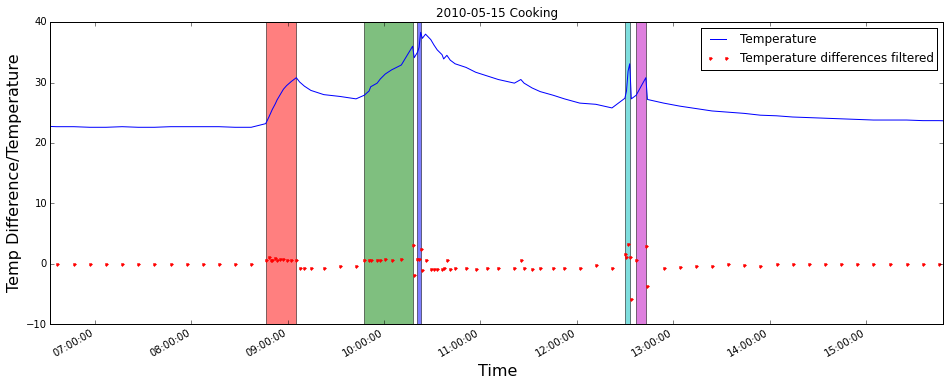

In [22]:
color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm','y'])
fig = plt.figure()
ax = dframes4.plot(x='datetime', y='value', label="Temperature")
text = str(dframes4.datetime.min().date()) + " Cooking"
for ce, color in zip(grp.index.values, color_iter):
#    text += "cluster:" + str(ce) + ",start: " + str(dframes4[dframes4.hcluster==ce].datetime.min().time()) + ",mean:" + str(time.strftime('%H:%M:%S', time.gmtime(mean))) + ",end: " + str(dframes4[dframes4.hcluster==ce].datetime.max().time()) + "\n"
    ax.axvspan(dframes4[dframes4.cooking_event==ce].datetime.min(), dframes4[dframes4.cooking_event==ce].datetime.max(), facecolor=color, alpha=0.5, label='shit')  
dframes4.plot(x='datetime', y='valuediffauto', style='.', color='r', ax=ax, title=text, label="Temperature differences filtered")
plt.xlabel('Time', fontsize=16)
plt.ylabel('Temp Difference/Temperature', fontsize=16)
print plt.ylim()
print plt.xlim()
plt.xlim(733907.27240740739,733907.65846064812)
plt.show(fig)

In [23]:
cookevents = grp.index.values
mergeddf = pd.DataFrame()
for cg in cookevents:
    mergeddf = pd.concat([mergeddf,pd.DataFrame(dframes4[dframes4['cooking_event']==cg])], axis=0)

In [24]:
dframes4[dframes4.cooking_event==g].datetime.max().time()

datetime.time(12, 42, 59)

In [29]:
data = mergeddf[['msseconddelta', 'valuebit']].values
print data

# clustering
thresh = 1000
clusters = hcluster.fclusterdata(data, thresh, criterion="distance")

[[31577.431 True]
 [31697.919 True]
 [31758.165 True]
 [31818.41 True]
 [31938.9 True]
 [31999.146 True]
 [32119.634 True]
 [32240.124 True]
 [32360.613 True]
 [32541.343 True]
 [32722.074 True]
 [35259.123 True]
 [35439.854 True]
 [35500.101 True]
 [35741.075 True]
 [35861.565 True]
 [36042.295 True]
 [36283.267 True]
 [36644.724 True]
 [37066.421 True]
 [37247.167 True]
 [37307.415 True]
 [37367.872 True]
 [44996.353 True]
 [45056.601 True]
 [45116.846 True]
 [45177.093 True]
 [45418.07 True]
 [45779.528 True]]


(0.99199999999999999, 1.008)
(30000.0, 48000.0)


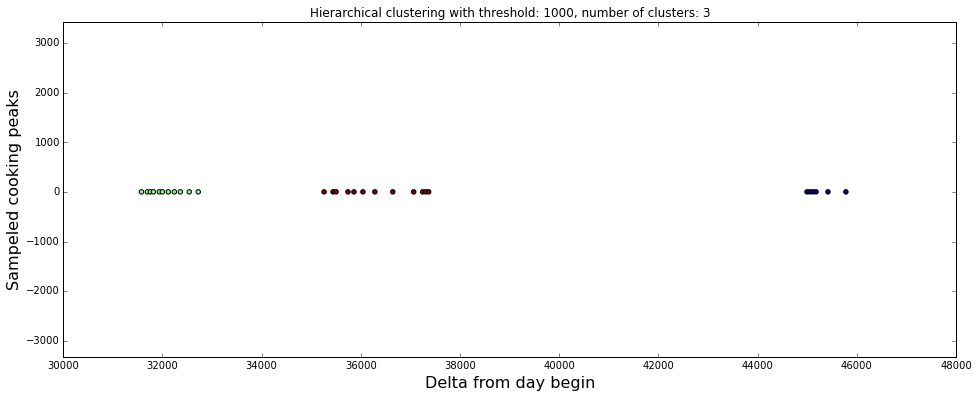

In [45]:
# plotting
fig = plt.figure()
ax = plt.scatter(*np.transpose(data), c=clusters)
plt.axis("equal")
#title = "threshold: %i, number of clusters: %d" % (thresh, len(set(clusters)))
title = "Hierarchical clustering with threshold: %i, number of clusters: %d" % (thresh, len(set(clusters)))
plt.title(title)
print plt.ylim()
print plt.xlim()
plt.ylabel('Sampeled cooking peaks', fontsize=16)
plt.xlabel('Delta from day begin', fontsize=16)
plt.ylim(1.007,100)
plt.show(fig)

[[  2.40000000e+01   2.50000000e+01   6.02450000e+01   2.00000000e+00]
 [  2.00000000e+00   3.00000000e+00   6.02450000e+01   2.00000000e+00]
 [  4.00000000e+00   5.00000000e+00   6.02460000e+01   2.00000000e+00]
 [  1.20000000e+01   1.30000000e+01   6.02470000e+01   2.00000000e+00]
 [  2.00000000e+01   2.10000000e+01   6.02480000e+01   2.00000000e+00]
 [  1.00000000e+00   3.00000000e+01   9.03685000e+01   3.00000000e+00]
 [  2.60000000e+01   2.90000000e+01   9.03695000e+01   3.00000000e+00]
 [  2.20000000e+01   3.30000000e+01   9.05810000e+01   3.00000000e+00]
 [  7.00000000e+00   8.00000000e+00   1.20489000e+02   2.00000000e+00]
 [  1.40000000e+01   1.50000000e+01   1.20490000e+02   2.00000000e+00]
 [  2.30000000e+01   3.50000000e+01   1.20493667e+02   4.00000000e+00]
 [  6.00000000e+00   3.10000000e+01   1.50611000e+02   3.00000000e+00]
 [  9.00000000e+00   1.00000000e+01   1.80731000e+02   2.00000000e+00]
 [  0.00000000e+00   3.40000000e+01   1.80733667e+02   4.00000000e+00]
 [  1.

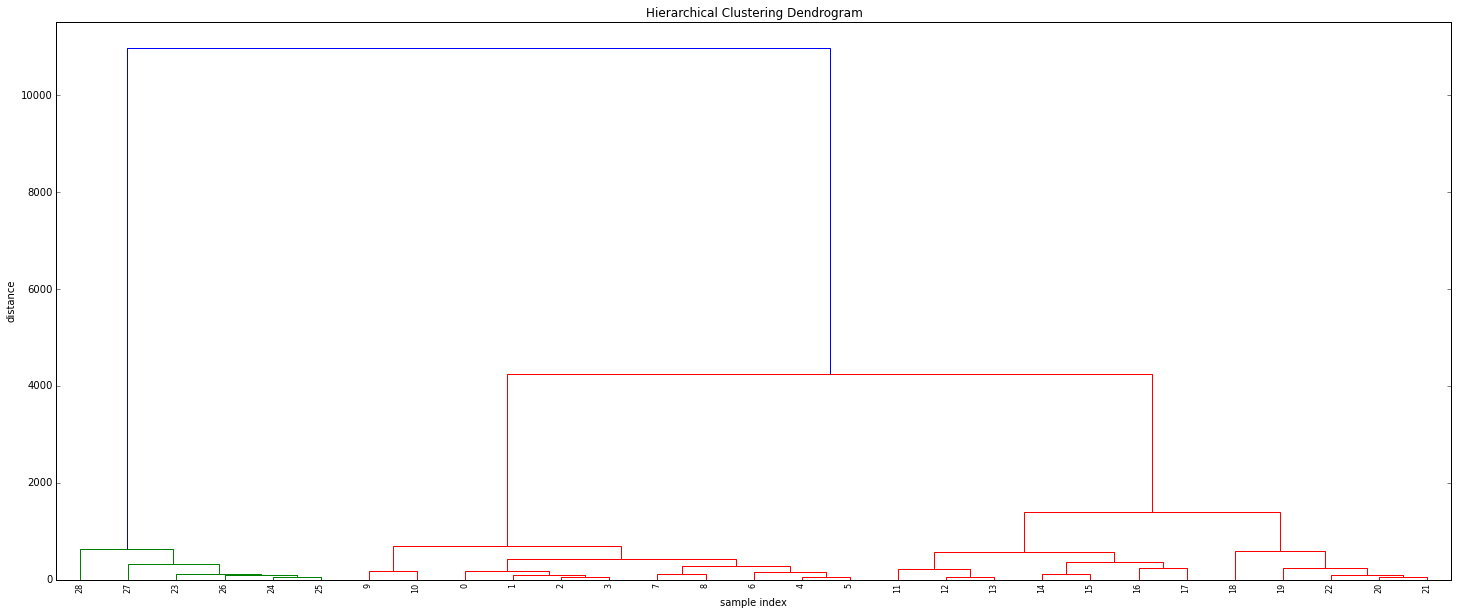

In [46]:
# calculate full dendrogram
Z = linkage(data, 'centroid')
print Z
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [47]:
## append clusterNr to dataframe
for cluster in set(clusters):
    for point in data[clusters==cluster, 0]:
        #print point , "c:", cluster
        dframes4.loc[dframes4.msseconddelta == point, 'hcluster'] = cluster

In [52]:
#sequence: A , duration [sec: 1265.1 min:  21.1 ], start: 08:46:17 ,end: 09:05:22 ,count events: 11
#sequence: B , duration [sec: 1867.5 min:  31.1 ], start: 09:47:39 ,end: 10:17:46 ,count events: 9
#sequence: C , duration [sec: 182.0 min:  3.0 ], start: 10:20:47 ,end: 10:22:47 ,count events: 3
#sequence: D , duration [sec: 241.0 min:  4.0 ], start: 12:29:56 ,end: 12:32:57 ,count events: 4
#sequence: E , duration [sec: 421.7 min:  7.0 ], start: 12:36:58 ,end: 12:42:59 ,count events: 2

grp2 = dframes4.groupby('hcluster').sum()
print grp2
for g, ce in zip(grp2.index, grp2.index.values):
    print 'hcluster:', int(g), ', duration [sec:', round(grp2['msseconddeltadiff'][ce],1), 'min: ', round(grp2['msseconddeltadiff'][ce]/60,1), "], start:", dframes4[dframes4.hcluster==g].datetime.min().time(), "end:", dframes4[dframes4.hcluster==g].datetime.max().time(), ", count events:", int(grp2['valuebit'][g]) 

            ms  event_subtype  sensor_id        z     x   y  value  \
hcluster                                                             
1         2491              0         24  3534074  1038   6  179.7   
2         4759              0         44  6407296  1903  11  298.9   
3         4879              0         48  7008237  2076  12  387.8   

            something  seconddelta  msseconddelta  valuediff  valuediffauto  \
hcluster                                                                      
1         12784238598       271542     271544.491       10.8           10.8   
2         23437770763       352769     352773.759        8.2            8.2   
3         25568477196       435756     435760.879       12.9           12.9   

          valuebit  blockevent_counter  msseconddeltadiff  
hcluster                                                   
1                6                   7            662.690  
2               11                  55           1265.132  
3            

In [53]:
cookevents2 = grp2[grp2.msseconddeltadiff > MINIMUM_COOKING_TIME].index.values
cluster_number2 = len(cookevents2)

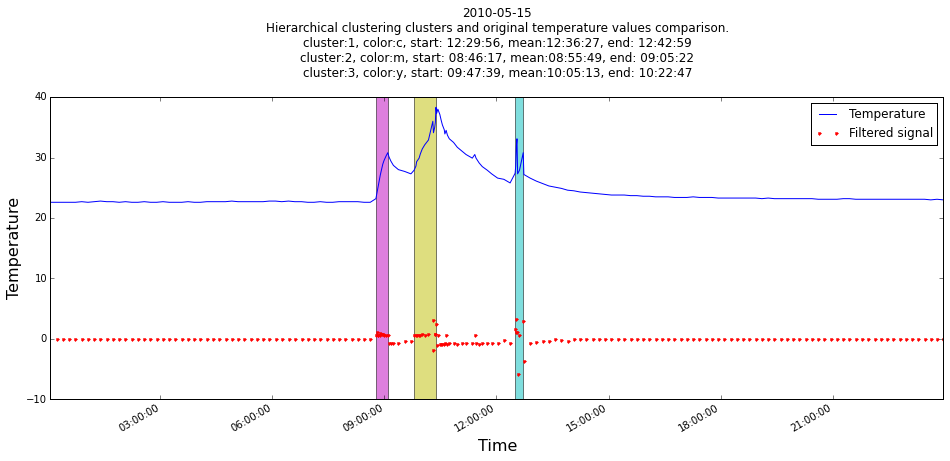

In [67]:
fig = plt.figure()
ax = dframes4.plot(x='datetime', y='value', label="Temperature")
#text = str(dframes4.datetime.min().date()) + "\n"
text = str(dframes4.datetime.min().date()) + "\n"+"Hierarchical clustering clusters and original temperature values comparison.\n"
for ce, color in zip (cookevents2, color_iter):
    mean = (dframes4[dframes4.hcluster==ce].msseconddelta.min() + dframes4[dframes4.hcluster==ce].msseconddelta.max())/2
    text += "cluster:" + str(int(ce)) + ", color:"+ color +", start: " + str(dframes4[dframes4.hcluster==ce].datetime.min().time()) + ", mean:" + str(time.strftime('%H:%M:%S', time.gmtime(mean))) + ", end: " + str(dframes4[dframes4.hcluster==ce].datetime.max().time()) + "\n"
    ax.axvspan(dframes4[dframes4.hcluster==ce].datetime.min(), dframes4[dframes4.hcluster==ce].datetime.max(), facecolor=color, alpha=0.5)
dframes4.plot(x='datetime', y='valuediffauto', style='.', color='r', ax=ax, title=text, label="Filtered signal")
plt.xlabel('Time', fontsize=16)
plt.ylabel('Temperature', fontsize=16)
plt.show(fig)

In [63]:
############## DPGMM ##############

# defined by cooking groups number
cluster_number1 = len(cookevents)
# defined by hierarchical clustering cluster number 
cluster_number2 = len(cookevents2)

cluster_number1 = len(cookevents)
astimated_cluster_number = cluster_number1
if cluster_number1 > 1:
    astimated_cluster_number = cluster_number2

color_iter = itertools.cycle(['r', 'g', 'b', 'c', 'm','y'])

dpgmm = mixture.DPGMM(n_components=astimated_cluster_number, covariance_type='full', params='wc', n_iter=1000)
dpgmm.fit(data)

## append clusterNr to dataframe
Y = dpgmm.predict(data)

#dpgmmclusterlist = []

#outputDict[key]["clusters"] = len(dpgmm.means_)
for i, (mean, covar, weight) in enumerate(zip(dpgmm.means_, dpgmm._get_covars(), dpgmm.weights_)):
        meanx = mean[0]
        for z in enumerate(data[Y==i,0]):
            # append cluster# to row
            dframes4.loc[dframes4.msseconddelta == z[1], 'dpgmmcluster'] = i

        print "date:", dframes4[dframes4.dpgmmcluster==i].datetime.min().date(),",cluster:", i, ",elements:",len(data[Y==i,0]), "mean:", mean[0],time.strftime('%H:%M:%S', time.gmtime(mean[0])), ",start: ", dframes4[dframes4.dpgmmcluster==i].datetime.min().time(), ",end:", dframes4[dframes4.dpgmmcluster==i].datetime.max().time()
        # listID,mssecondmean, timemean, start, end
        newList = [i, mean[0], time.strftime('%H:%M:%S', time.gmtime(mean[0])), dframes4[dframes4.dpgmmcluster==i].datetime.min().time(), dframes4[dframes4.dpgmmcluster==i].datetime.max().time()]
        #outputDict[key][i] = newList

date: 2010-05-15 ,cluster: 0 ,elements: 11 mean: 32070.3417273 08:54:30 ,start:  08:46:17 ,end: 09:05:22
date: 2010-05-15 ,cluster: 1 ,elements: 6 mean: 45257.4151667 12:34:17 ,start:  12:29:56 ,end: 12:42:59
date: 2010-05-15 ,cluster: 2 ,elements: 12 mean: 36313.4065833 10:05:13 ,start:  09:47:39 ,end: 10:22:47


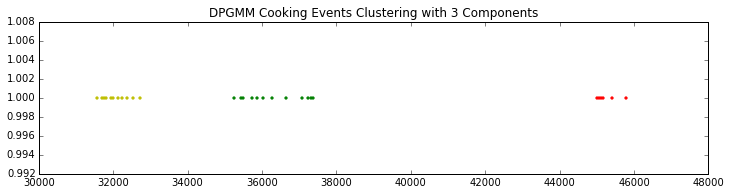

In [64]:
#mergedCT = data
dpgmm = mixture.DPGMM(n_components=len(cookevents2), covariance_type='full', params='cw', n_iter=1000)
dpgmm.fit(data)

for i, (clf, title) in enumerate([(dpgmm, 'DPGMM Cooking Events Clustering with 3 Components')]):
    splot = plt.subplot(2, 1, 1 + i)
    Y_ = clf.predict(data)
    for i, (mean, covar, color) in enumerate(zip(
            clf.means_, clf._get_covars(), color_iter)):
        v, w = linalg.eigh(covar)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(data[Y_ == i, 0], data[Y_ == i, 1], 5, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        #splot.add_artist(ell)

    plt.title(title)